In [2]:
import numpy as np

import networkx as nx

import scipy.stats as st

import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

# Augmented FR functions

In [3]:
def AugFormanPl(e,G): # Returns plain curvature. Arguments: an edge e of a graph G
    return 4-len(G[e[0]])-len(G[e[1]])

In [4]:
def AugFormanT(e,G): # Returns triangle-augmented curvature. Arguments: an edge e of a graph G
            
    return 4-len(G[e[0]])-len(G[e[1]])+3*len(set(G[e[0]]) & set(G[e[1]]))

In [5]:
def AugFormanSq(e,G): # Returns square-augmented curvature. Arguments: an edge e of a graph G
    
    E=np.zeros([len(G), len(G)]) #Matrix of edge contributions
    FR=0
   
    #Add a -1 to the contribution of all edges sharing a node with e
    for i in (set(G[e[0]]) - {e[1]}):
         E[min(e[0],i)][max(e[0],i)] = -1
    
    for i in (set(G[e[1]]) - {e[0]}):
         E[min(e[1],i)][max(e[1],i)] = -1
    
    #Count triangles, and add +1 to the contribution of edges contained in a triangle with e
    T=len(set(G[e[0]]) & set(G[e[1]]))

    
    for i in (set(G[e[0]]) & set(G[e[1]])):
        E[min(e[0],i)][max(e[0],i)] += 1
        E[min(e[1],i)][max(e[1],i)] += 1
    
    #Count squares,
    #Add +1 to each edge neighbour to e contained in a square with it
    #Add +1 or -1 for edges not touching e contained in a square with it (the matrix lets us keep track of both orientations separately)
    Sq=0
    neigh_0= [i for i in G[e[0]] if i!=e[1]]
    for i in neigh_0:
        for j in (set(G[i]) & set(G[e[1]]) - {e[0]}):
            Sq +=1
            E[min(e[0],i)][max(e[0],i)] += 1
            E[min(e[1],j)][max(e[1],j)] += 1
            E[i][j] += 1
    
    
    FR += 2 + T + Sq

    for i in range(len(G)):
        for j in range(i,len(G)):
            FR += -abs(E[i][j]-E[j][i])
            
    return FR

In [6]:
def AugFormanPent(e,G): # Returns pentagon-augmented curvature. Arguments: an edge e of a graph G
    
    E=np.zeros([len(G), len(G)]) #Matrix of edge contributions
    FR=0
   
    #Add a -1 to the contribution of all edges sharing a node with e
    for i in (set(G[e[0]]) - {e[1]}):
         E[min(e[0],i)][max(e[0],i)] = -1
    
    for i in (set(G[e[1]]) - {e[0]}):
         E[min(e[1],i)][max(e[1],i)] = -1
    
    #Count triangles, and add +1 to the contribution of edges contained in a triangle with e
    T=len(set(G[e[0]]) & set(G[e[1]]))

    
    for i in (set(G[e[0]]) & set(G[e[1]])):
        E[min(e[0],i)][max(e[0],i)] += 1
        E[min(e[1],i)][max(e[1],i)] += 1
    
    #Count squares,
    #Add +1 to each edge neighbour to e contained in a square with it
    #Add +1 or -1 for edges not touching e contained in a square with it (the matrix lets us keep track of both orientations separately)
    Sq=0
    neigh_0= [i for i in G[e[0]] if i!=e[1]]
    for i in neigh_0:
        for j in (set(G[i]) & set(G[e[1]]) - {e[0]}):
            Sq +=1
            E[min(e[0],i)][max(e[0],i)] += 1
            E[min(e[1],j)][max(e[1],j)] += 1
            E[i][j] += 1
    

    #Same as with squares, but for pentagons        
    Pent=0
    neigh_1= [i for i in G[e[1]] if i!=e[0]]
    for i in neigh_0:
        for j in neigh_1:
            if i != j:
                for k in (set(G[i]) & set(G[j]) - {e[0],e[1]}):
                    Pent += 1
                    E[min(e[0],i)][max(e[0],i)] += 1
                    E[min(e[1],j)][max(e[1],j)] += 1
                    E[i][k] += 1
                    E[k][j] += 1
    
    FR += 2 + T + Sq + Pent

    for i in range(len(G)):
        for j in range(i,len(G)):
            FR += -abs(E[i][j]-E[j][i])
            
    return FR

# Hierarchical bipartite functions

In [7]:
def HierarchBipar(n,p,q): # Returns a hierarchical bipartite graph of 4n nodes, in probability p, and out probability q
    
    sizes = [n, n, n, n]
    probs = [[0, p, 0, q], [p, 0, q, 0], [0, q, 0, p], [q, 0, p, 0]]
    
    return nx.stochastic_block_model(sizes, probs)

In [8]:
#Experimental "expected" square weight (i.e. computed in the same way as the theoretical weight) for edges inside communities

def Expected_in_bipar(G,n,List): #Arguments: hierarchical bipartite graph G of 4n nodes. List is a 4nx4n matrix that contains the square-augmented curvature values of the edges. 
    
    wT = 3

    LT=[]
    LSq=[]
    Ldeg0=[]
    Ldeg1=[]
    LFR=[]

    for e in G.edges():
        if e[1]<2*n or e[0]>2*n-1:
            T=len((set(G[e[0]]) & set(G[e[1]])))
    
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
    
            LT.append(T)
            LSq.append(Sq)
            Ldeg0.append(G.degree[e[0]])
            Ldeg1.append(G.degree[e[1]])
            LFR.append(List[e[0],e[1]])
    
    if np.mean(LSq)>0:
        return (np.mean(LFR)-4+np.mean(Ldeg0)+np.mean(Ldeg1)-wT*np.mean(LT))/np.mean(LSq)
    
    else:
        print('Error: not enough squares')
        return 2 #As it is the limit when the number of overlapping squares tends to 0
    

In [9]:
#Same as cell above, now for out edges
def Expected_out_bipar(G,n,List):
    
    wT = 3

    LT=[]
    LSq=[]
    Ldeg0=[]
    Ldeg1=[]
    LFR=[]

    for e in G.edges():
        
        if e[0]<2*n and e[1]>2*n-1:
            T=len((set(G[e[0]]) & set(G[e[1]])))
    
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
    
            LT.append(T)
            LSq.append(Sq)
            Ldeg0.append(G.degree[e[0]])
            Ldeg1.append(G.degree[e[1]])
            LFR.append(List[e[0],e[1]])
    
    if np.mean(LSq)>0:
        return (np.mean(LFR)-4+np.mean(Ldeg0)+np.mean(Ldeg1)-wT*np.mean(LT))/np.mean(LSq)
    
    else:
        print('Error: not enough squares')
        return 2
    

In [10]:
#Total "expected" square weight
def Expected_bipar(G,w_in,w_out): #Bipartite graph G, w_in=expected weight of in-edges, w_out=expected weight of out-edges
    
    E_in=0

    for e in G.edges():
        if e[1]<2*n or e[0]>2*n-1:
            E_in+=1
        
    return (w_in*E_in + w_out*(len(G.edges())-E_in))/len(G.edges())

In [11]:
#Experimental actual average weights for edges inside communities
def Average_in_bipar(G,n,List): #Arguments same as for Expected_in_bipar
    
    wT =3
    wSq=[]

    for e in G.edges():
        if e[1]<2*n or e[0]>2*n-1:
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
    
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
            if Sq != 0:
                T=len((set(G[e[0]]) & set(G[e[1]])))
                wSq.append((List[e[0],e[1]]-4+G.degree[e[0]]-4+G.degree[e[1]]-wT*T)/Sq)
        
    return np.mean(wSq)
    

In [12]:
def Average_out_bipar(G,n,List): #Arguments same as for Expected_in_bipar
    
    wT =3
    wSq=[]

    for e in G.edges():
        if e[0]<2*n and e[1]>2*n-1:
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
    
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
            if Sq != 0:
                T=len((set(G[e[0]]) & set(G[e[1]])))
                wSq.append((List[e[0],e[1]]-4+G.degree[e[0]]-4+G.degree[e[1]]-wT*T)/Sq)
        
    return np.mean(wSq)

In [13]:
def Average_bipar(G,w_in,w_out):#Arguments same as for Expected_bipar
    
    E_in=0
    
    for e in G.edges():
        if e[1]<2*n or e[0]>2*n-1:
            E_in+=1
        
    return (w_in*E_in + w_out*(len(G.edges())-E_in))/len(G.edges())

# SBM Functions

In [14]:
def SBM(n,p,q): # Returns an SBM of 4 communities and n nodes per comm., in probability p, out probability q
    
    sizes = [n, n, n, n]
    probs = [[p, q, q, q], [q, p, q, q], [q, q, p, q], [q, q, q, p]]
    
    return nx.stochastic_block_model(sizes, probs)

In [15]:
def Expected_in_SBM(G,n,List): #Arguments same as for Expected_in_bipar
    
    wT = 3

    LT=[]
    LSq=[]
    Ldeg0=[]
    Ldeg1=[]
    LFR=[]

    for e in G.edges():
        if e[0]<n and e[1]<n:
            T=len((set(G[e[0]]) & set(G[e[1]])))
    
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
    
            LT.append(T)
            LSq.append(Sq)
            Ldeg0.append(G.degree[e[0]])
            Ldeg1.append(G.degree[e[1]])
            LFR.append(List[e[0],e[1]])
        
        if e[0]>n-1 and e[0]<2*n and e[1]>n-1 and e[1]<2*n:
            T=len((set(G[e[0]]) & set(G[e[1]])))
    
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
    
            LT.append(T)
            LSq.append(Sq)
            Ldeg0.append(G.degree[e[0]])
            Ldeg1.append(G.degree[e[1]])
            LFR.append(List[e[0],e[1]])
            
        if e[0]>2*n-1 and e[0]<3*n and e[1]>2*n-1 and e[1]<3*n:
            T=len((set(G[e[0]]) & set(G[e[1]])))
    
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
    
            LT.append(T)
            LSq.append(Sq)
            Ldeg0.append(G.degree[e[0]])
            Ldeg1.append(G.degree[e[1]])
            LFR.append(List[e[0],e[1]])
            
        if e[0]>3*n-1 and e[1]>3*n-1:
            T=len((set(G[e[0]]) & set(G[e[1]])))
    
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
    
            LT.append(T)
            LSq.append(Sq)
            Ldeg0.append(G.degree[e[0]])
            Ldeg1.append(G.degree[e[1]])
            LFR.append(List[e[0],e[1]])
    
    if np.mean(LSq)>0:
        return (np.mean(LFR)-4+np.mean(Ldeg0)+np.mean(Ldeg1)-wT*np.mean(LT))/np.mean(LSq)
    
    else:
        print('Error: not enough squares')
        return 2
    

In [16]:
def Expected_out_SBM(G,n,List): #Arguments same as for Expected_in_bipar
    
    wT =3
    LT=[]
    LSq=[]
    Ldeg0=[]
    Ldeg1=[]
    LFR=[]

    for e in G.edges():        
        T=len((set(G[e[0]]) & set(G[e[1]])))
    
        Sq=0
        neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
        for i in neigh_0:
            Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
    
        LT.append(T)
        LSq.append(Sq)
        Ldeg0.append(G.degree[e[0]])
        Ldeg1.append(G.degree[e[1]])
        LFR.append(List[e[0],e[1]])
        
    if np.mean(LSq)>0:
        return (np.mean(LFR)-4+np.mean(Ldeg0)+np.mean(Ldeg1)-wT*np.mean(LT))/np.mean(LSq)
    
    else:
        print('Error: not enough squares')
        return 2

In [17]:
def Expected_SBM(G,w_in,w_out): #Arguments same as for Expected_bipar
    
    E_in=0
    
    for e in G.edges():
        if e[0]<n and e[1]<n:
            E_in += 1
        
        if e[0]>n-1 and e[0]<2*n and e[1]>n-1 and e[1]<2*n:
            E_in += 1
            
        if e[0]>2*n-1 and e[0]<3*n and e[1]>2*n-1 and e[1]<3*n:
            E_in += 1
            
        if e[0]>3*n-1 and e[1]>3*n-1:
            E_in += 1
        
    return (w_in*E_in + w_out*(len(G.edges())-E_in))/len(G.edges())

In [18]:
def Average_in_SBM(G,n,List): #Arguments same as for Expected_in_bipar
    
    wT =3
    wSq=[]

    for e in G.edges():
        if e[0]<n and e[1]<n:
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
    
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
            if Sq != 0:
                T=len((set(G[e[0]]) & set(G[e[1]])))
                wSq.append((List[e[0],e[1]]-4+G.degree[e[0]]-4+G.degree[e[1]]-wT*T)/Sq)
                
        if e[0]>n-1 and e[0]<2*n and e[1]>n-1 and e[1]<2*n:
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
    
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
            if Sq != 0:
                T=len((set(G[e[0]]) & set(G[e[1]])))
                wSq.append((List[e[0],e[1]]-4+G.degree[e[0]]-4+G.degree[e[1]]-wT*T)/Sq)
        
        if e[0]>2*n-1 and e[0]<3*n and e[1]>2*n-1 and e[1]<3*n:
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
    
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
            if Sq != 0:
                T=len((set(G[e[0]]) & set(G[e[1]])))
                wSq.append((List[e[0],e[1]]-4+G.degree[e[0]]-4+G.degree[e[1]]-wT*T)/Sq)
                
        if e[0]>3*n-1 and e[1]>3*n-1:
            Sq=0
            neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
    
            for i in neigh_0:
                Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
            if Sq != 0:
                T=len((set(G[e[0]]) & set(G[e[1]])))
                wSq.append((List[e[0],e[1]]-4+G.degree[e[0]]-4+G.degree[e[1]]-wT*T)/Sq)
        
    return np.mean(wSq)

In [19]:
def Average_out_SBM(G,n,List): #Arguments same as for Expected_in_bipar
    
    wT =3
    wSq=[]

    for e in G.edges():
        if e[0]<n and e[1]<n:
            continue
        
        if e[0]>n-1 and e[0]<2*n and e[1]>n-1 and e[1]<2*n:
            continue
            
        if e[0]>2*n-1 and e[0]<3*n and e[1]>2*n-1 and e[1]<3*n:
            continue
            
        if e[0]>3*n-1 and e[1]>3*n-1:
            continue
        
        Sq=0
        neigh_0= [n for n in G.neighbors(e[0]) if n!=e[1]]
    
        for i in neigh_0:
            Sq += len(set(G[i]) & set(G[e[1]]) - {e[0]})
        
        if Sq != 0:
            T=len((set(G[e[0]]) & set(G[e[1]])))
            wSq.append((List[e[0],e[1]]-4+G.degree[e[0]]-4+G.degree[e[1]]-wT*T)/Sq)
        
    return np.mean(wSq)

In [20]:
def Average_SBM(G,w_in,w_out): #Arguments same as for Expected_bipar
    
    E_in=0
    
    for e in G.edges():
        if e[0]<n and e[1]<n:
            E_in += 1
        
        if e[0]>n-1 and e[0]<2*n and e[1]>n-1 and e[1]<2*n:
            E_in += 1
            
        if e[0]>2*n-1 and e[0]<3*n and e[1]>2*n-1 and e[1]<3*n:
            E_in += 1
            
        if e[0]>3*n-1 and e[1]>3*n-1:
            E_in += 1
        
    return (w_in*E_in + w_out*(len(G.edges())-E_in))/len(G.edges())

# Curvature Gap Functions

In [21]:
#Bipartite
def Curv_gap_bipar(G): #G is a graph
    
    FRList_in_Sq = []
    FRList_out_Sq = []

    for e in G.edges():
        if e[1]<2*n or e[0]>2*n-1:
            FRList_in_Sq.append(AugFormanSq(e,G))
        else:
            FRList_out_Sq.append(AugFormanSq(e,G))
            
    return (np.mean(FRList_in_Sq)-np.mean(FRList_out_Sq))/(np.sqrt((np.var(FRList_in_Sq)+np.var(FRList_out_Sq))/2))

In [22]:
#SBM
def Curv_gap_SBM(G): #G is a graph
    
    FRList_in_Sq = []
    FRList_out_Sq = []

    for e in G.edges():
        
        if e[0]<n and e[1]<n:
            FRList_in_Sq.append(AugFormanSq(e,G))
            continue
        
        if e[0]>n-1 and e[0]<2*n and e[1]>n-1 and e[1]<2*n:
            FRList_in_Sq.append(AugFormanSq(e,G))
            continue
            
        if e[0]>2*n-1 and e[0]<3*n and e[1]>2*n-1 and e[1]<3*n:
            FRList_in_Sq.append(AugFormanSq(e,G))      
            continue
            
        if e[0]>3*n-1 and e[1]>3*n-1:
            FRList_in_Sq.append(AugFormanSq(e,G))
            continue
            
        FRList_out_Sq.append(AugFormanSq(e,G))
            
    return (np.mean(FRList_in_Sq)-np.mean(FRList_out_Sq))/(np.sqrt((np.var(FRList_in_Sq)+np.var(FRList_out_Sq))/2))

# Hierarchical Bipartite average square weights

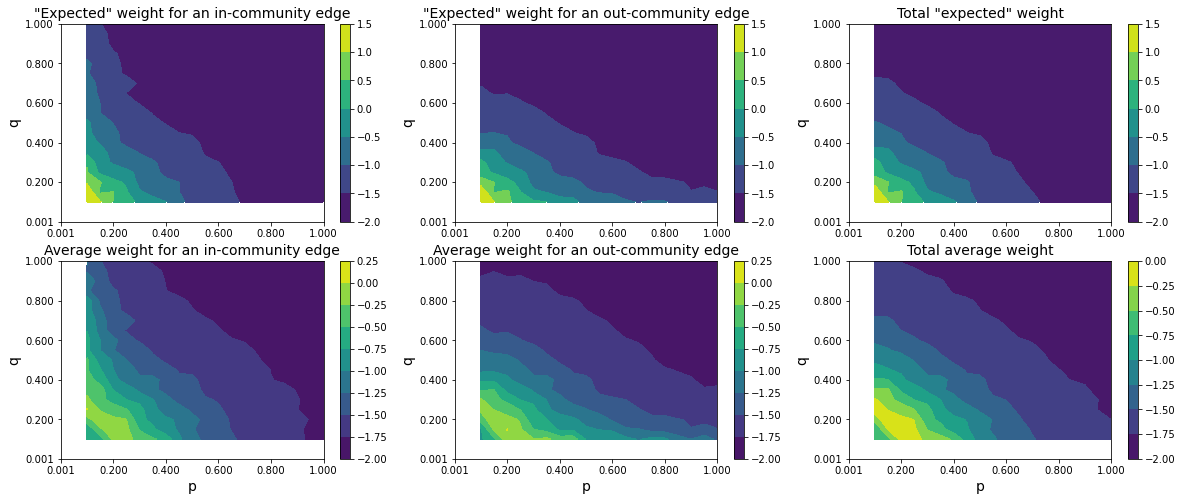

In [134]:
# Average and expected weight of hierarchical bipartite graph

n=20
P, Q = np.meshgrid(np.arange(0.1, 1.05, 0.05), np.arange(0.1, 1.05, 0.05))

exp_weight_in=np.zeros([19,19])
exp_weight_out=np.zeros([19,19])
exp_weight=np.zeros([19,19])

avg_weight_in=np.zeros([19,19])
avg_weight_out=np.zeros([19,19])
avg_weight=np.zeros([19,19])

for p in range(0,19):
    for q in range(0,19):
        G=HierarchBipar(n, 0.1+0.05*p,0.1+0.05*q)
        FRList=np.zeros([len(G),len(G)])
        
        for e in G.edges():
            FRList[e[0],e[1]] = AugFormanSq(e,G)

        exp_weight_in[q,p]=Expected_in_bipar(G,n,FRList)
        exp_weight_out[q,p]=Expected_out_bipar(G,n,FRList)
        exp_weight[q,p]=Expected_bipar(G,exp_weight_in[q,p],exp_weight_out[q,p])
        
        avg_weight_in[q,p]=Average_in_bipar(G,n,FRList)
        avg_weight_out[q,p]=Average_out_bipar(G,n,FRList)
        avg_weight[q,p]=Average_bipar(G,avg_weight_in[q,p],avg_weight_out[q,p])


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

ax00 = ax[0,0].contourf(P, Q, exp_weight_in)
ax[0,0].set_ylabel('q',size=14)
ax[0,0].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,0].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,0].set_title('"Expected" weight for an in-community edge',size=14)
fig.colorbar(ax00, ax=ax[0,0])

ax01=ax[0,1].contourf(P, Q, exp_weight_out)
ax[0,1].set_ylabel('q',size=14)
ax[0,1].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,1].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,1].set_title('"Expected" weight for an out-community edge',size=14)
fig.colorbar(ax01, ax=ax[0,1])

ax02=ax[0,2].contourf(P, Q, exp_weight)
ax[0,2].set_ylabel('q',size=14)
ax[0,2].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,2].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,2].set_title('Total "expected" weight',size=14)
fig.colorbar(ax02, ax=ax[0,2])

ax10 = ax[1,0].contourf(P, Q, avg_weight_in)
ax[1,0].set_xlabel('p',size=14)
ax[1,0].set_ylabel('q',size=14)
ax[1,0].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,0].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,0].set_title('Average weight for an in-community edge',size=14)
fig.colorbar(ax10, ax=ax[1,0])

ax11=ax[1,1].contourf(P, Q, avg_weight_out)
ax[1,1].set_xlabel('p',size=14)
ax[1,1].set_ylabel('q',size=14)
ax[1,1].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,1].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,1].set_title('Average weight for an out-community edge',size=14)
fig.colorbar(ax11, ax=ax[1,1])

ax12=ax[1,2].contourf(P, Q, avg_weight)
ax[1,2].set_xlabel('p',size=14)
ax[1,2].set_ylabel('q',size=14)
ax[1,2].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,2].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,2].set_title('Total average weight',size=14)
fig.colorbar(ax12, ax=ax[1,2])



plt.show()

# SBM average square weights

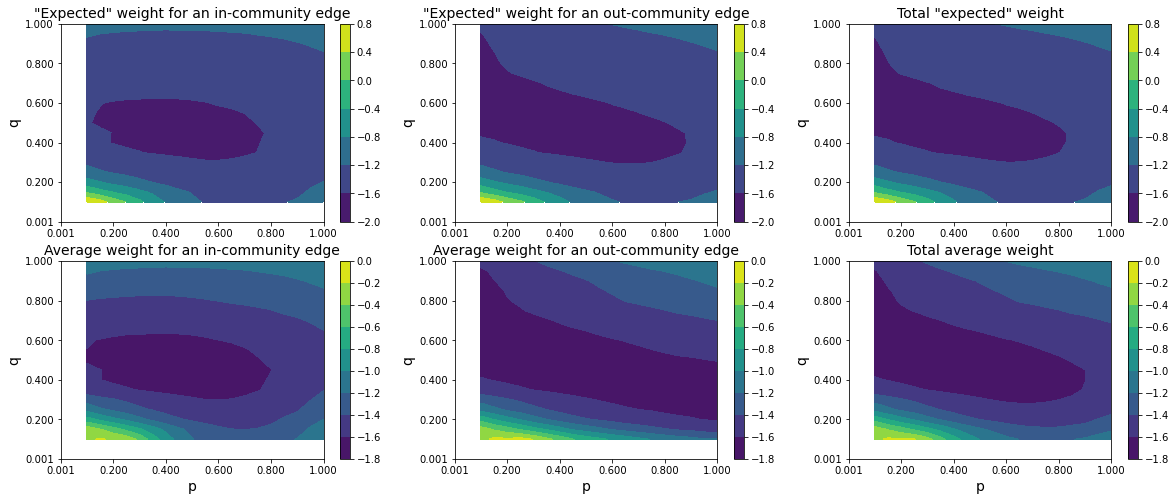

In [21]:
# Average and expected weight of SBM

n=20
P, Q = np.meshgrid(np.arange(0.1, 1.05, 0.05), np.arange(0.1, 1.05, 0.05))

exp_weight_in=np.zeros([19,19])
exp_weight_out=np.zeros([19,19])
exp_weight=np.zeros([19,19])

avg_weight_in=np.zeros([19,19])
avg_weight_out=np.zeros([19,19])
avg_weight=np.zeros([19,19])

for p in range(0,19):
    for q in range(0,19):
        G=SBM(n, 0.1+0.05*p,0.1+0.05*q)
        FRList=np.zeros([len(G),len(G)])
        
        for e in G.edges():
            FRList[e[0],e[1]] = AugFormanSq(e,G)

        exp_weight_in[q,p]=Expected_in_SBM(G,n,FRList)
        exp_weight_out[q,p]=Expected_out_SBM(G,n,FRList)
        exp_weight[q,p]=Expected_SBM(G,exp_weight_in[q,p],exp_weight_out[q,p])
        
        avg_weight_in[q,p]=Average_in_SBM(G,n,FRList)
        avg_weight_out[q,p]=Average_out_SBM(G,n,FRList)
        avg_weight[q,p]=Average_SBM(G,avg_weight_in[q,p],avg_weight_out[q,p])

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

ax00 = ax[0,0].contourf(P, Q, exp_weight_in)
ax[0,0].set_ylabel('q',size=14)
ax[0,0].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,0].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,0].set_title('"Expected" weight for an in-community edge',size=14)
fig.colorbar(ax00, ax=ax[0,0])

ax01=ax[0,1].contourf(P, Q, exp_weight_out)
ax[0,1].set_ylabel('q',size=14)
ax[0,1].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,1].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,1].set_title('"Expected" weight for an out-community edge',size=14)
fig.colorbar(ax01, ax=ax[0,1])

ax02=ax[0,2].contourf(P, Q, exp_weight)
ax[0,2].set_ylabel('q',size=14)
ax[0,2].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,2].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[0,2].set_title('Total "expected" weight',size=14)
fig.colorbar(ax02, ax=ax[0,2])

ax10 = ax[1,0].contourf(P, Q, avg_weight_in)
ax[1,0].set_xlabel('p',size=14)
ax[1,0].set_ylabel('q',size=14)
ax[1,0].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,0].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,0].set_title('Average weight for an in-community edge',size=14)
fig.colorbar(ax10, ax=ax[1,0])

ax11=ax[1,1].contourf(P, Q, avg_weight_out)
ax[1,1].set_xlabel('p',size=14)
ax[1,1].set_ylabel('q',size=14)
ax[1,1].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,1].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,1].set_title('Average weight for an out-community edge',size=14)
fig.colorbar(ax11, ax=ax[1,1])

ax12=ax[1,2].contourf(P, Q, avg_weight)
ax[1,2].set_xlabel('p',size=14)
ax[1,2].set_ylabel('q',size=14)
ax[1,2].set_xticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,2].set_yticks(np.append(0.001,np.arange(0.2, 1.1, 0.2)))
ax[1,2].set_title('Total average weight',size=14)
fig.colorbar(ax12, ax=ax[1,2])



plt.show()

# FR curvature distribution for Lukas' models

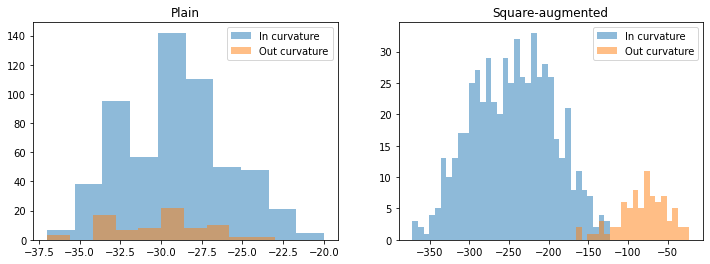

Plain curvature gap= 0.3744238829133199
Square curvature gap= 3.931055938689954


In [122]:
# Hierarchical Bipartite

n=20
p=0.7
q=0.1

G = HierarchBipar(n,p,q)

FRList_in_Pl = []
FRList_out_Pl =[]
FRList_in_Sq = []
FRList_out_Sq = []

for e in G.edges():
    if e[1]<2*n or e[0]>2*n-1:
        FRList_in_Pl.append(AugFormanPl(e,G))
        FRList_in_Sq.append(AugFormanSq(e,G))
    else:
        FRList_out_Pl.append(AugFormanPl(e,G))
        FRList_out_Sq.append(AugFormanSq(e,G))
        
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

bins0 = np.linspace(min(FRList_in_Pl), max(FRList_out_Pl), 100)
bins1 = np.linspace(min(FRList_in_Sq), max(FRList_out_Sq), 50)

ax[0].hist(FRList_in_Pl, alpha=0.5, label='In curvature')
ax[0].hist(FRList_out_Pl, alpha=0.5, label='Out curvature')
ax[0].legend(loc='upper right')
ax[0].set_title('Plain')

ax[1].hist(FRList_in_Sq, bins1, alpha=0.5, label='In curvature')
ax[1].hist(FRList_out_Sq, bins1, alpha=0.5, label='Out curvature')
ax[1].legend(loc='upper right')
ax[1].set_title('Square-augmented')

plt.show()
print("Plain curvature gap=",abs(np.mean(FRList_in_Pl)-np.mean(FRList_out_Pl))/(np.sqrt((np.var(FRList_in_Pl)+np.var(FRList_out_Pl))/2)))
print("Square curvature gap=",abs(np.mean(FRList_in_Sq)-np.mean(FRList_out_Sq))/(np.sqrt((np.var(FRList_in_Sq)+np.var(FRList_out_Sq))/2)))

Text(0.5, 0.5, 'q')

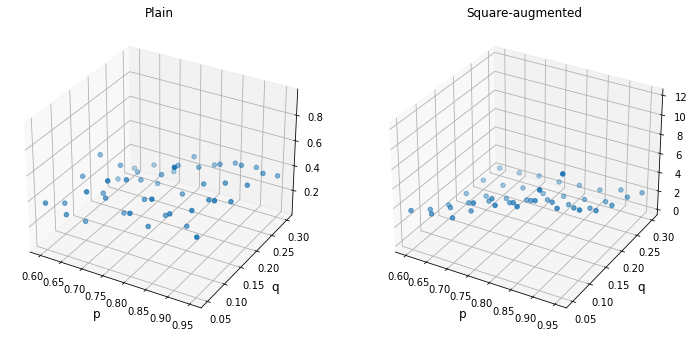

In [106]:
# Hierarchical Bipartite

n=20

PlGap=[]
SqGap=[]

for p in np.linspace(0.6,0.95,8):
    for q in np.linspace(0.05,0.3,6):
        G = HierarchBipar(n,p,q)

        FRList_in_Pl = []
        FRList_out_Pl =[]
        FRList_in_Sq = []
        FRList_out_Sq = []

        for e in G.edges():
            if e[1]<2*n or e[0]>2*n-1:
                FRList_in_Pl.append(AugFormanPl(e,G))
                FRList_in_Sq.append(AugFormanSq(e,G))
            else:
                FRList_out_Pl.append(AugFormanPl(e,G))
                FRList_out_Sq.append(AugFormanSq(e,G))

        PlGap.append((p,q,abs(np.mean(FRList_in_Pl)-np.mean(FRList_out_Pl))/(np.sqrt((np.var(FRList_in_Pl)+np.var(FRList_out_Pl))/2))))
        SqGap.append((p,q,abs(np.mean(FRList_in_Sq)-np.mean(FRList_out_Sq))/(np.sqrt((np.var(FRList_in_Sq)+np.var(FRList_out_Sq))/2))))
        
fig = plt.figure(figsize=(12,16))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D([x[0] for x in PlGap], [x[1] for x in PlGap], [x[2] for x in PlGap])
ax.set_title('Plain')
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D([x[0] for x in SqGap], [x[1] for x in SqGap], [x[2] for x in SqGap])
ax.set_title('Square-augmented')
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)


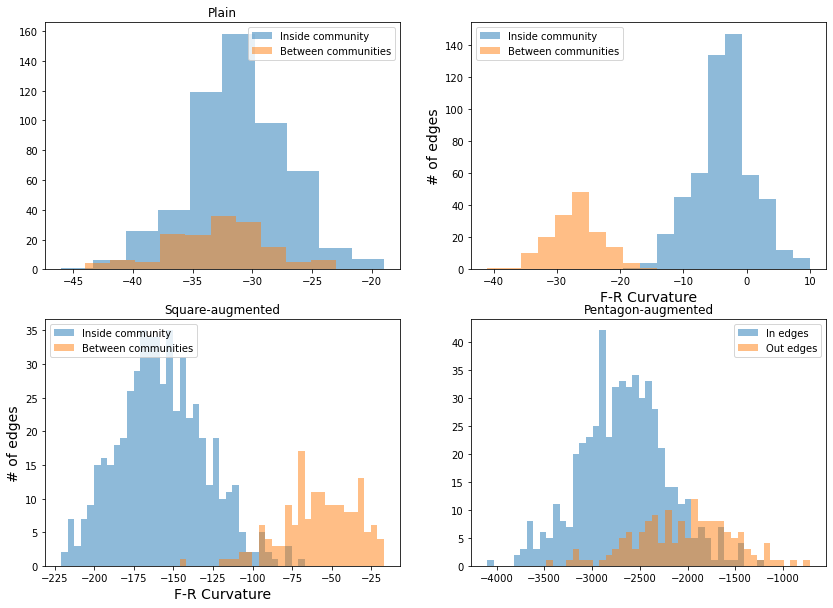

Plain curvature gap= 0.4326670670728509
Triangle curvature gap= 5.460445577368629
Square curvature gap= 3.876835617672761
Pentagon curvature gap= 1.292888608311115


In [23]:
#SBM

n=20
p=0.7
q=0.06

G = SBM(n,p,q)

FRList_in_Pl = []
FRList_out_Pl =[]
FRList_in_T = []
FRList_out_T =[]
FRList_in_Sq = []
FRList_out_Sq =[]
FRList_in_Pent = []
FRList_out_Pent =[]

for e in G.edges():
    if e[0]<n and e[1]<n:
        FRList_in_Pl.append(AugFormanPl(e,G))
        FRList_in_T.append(AugFormanT(e,G))
        FRList_in_Sq.append(AugFormanSq(e,G))
        FRList_in_Pent.append(AugFormanPent(e,G))
        continue
        
    if e[0]>n-1 and e[0]<2*n and e[1]>n-1 and e[1]<2*n:
        FRList_in_Pl.append(AugFormanPl(e,G))
        FRList_in_T.append(AugFormanT(e,G))
        FRList_in_Sq.append(AugFormanSq(e,G))
        FRList_in_Pent.append(AugFormanPent(e,G))
        continue
            
    if e[0]>2*n-1 and e[0]<3*n and e[1]>2*n-1 and e[1]<3*n:
        FRList_in_Pl.append(AugFormanPl(e,G))
        FRList_in_T.append(AugFormanT(e,G))
        FRList_in_Sq.append(AugFormanSq(e,G))
        FRList_in_Pent.append(AugFormanPent(e,G))
        continue
            
    if e[0]>3*n-1 and e[1]>3*n-1:
        FRList_in_Pl.append(AugFormanPl(e,G))
        FRList_in_T.append(AugFormanT(e,G))
        FRList_in_Sq.append(AugFormanSq(e,G))
        FRList_in_Pent.append(AugFormanPent(e,G))
        continue
        
    FRList_out_Pl.append(AugFormanPl(e,G))
    FRList_out_T.append(AugFormanT(e,G))    
    FRList_out_Sq.append(AugFormanSq(e,G))
    FRList_out_Pent.append(AugFormanPent(e,G))
    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

#bins0 = np.linspace(min(FRList_in_Pl), max(FRList_out_Pl), 100)
bins1 = np.linspace(min(FRList_out_T), max(FRList_in_T), 20)
bins2 = np.linspace(min(FRList_in_Sq), max(FRList_out_Sq), 50)
bins3 = np.linspace(min(FRList_in_Pent), max(FRList_out_Pent), 50)

ax[0,0].hist(FRList_in_Pl, alpha=0.5, label='Inside community')
ax[0,0].hist(FRList_out_Pl, alpha=0.5, label='Between communities')
ax[0,0].legend(loc='upper right')
ax[0,0].set_title('Plain')
FRList = FRList_in_T + FRList_out_T

ax[0,1].hist(FRList_in_T, bins1, alpha=0.5, label='Inside community')
ax[0,1].hist(FRList_out_T, bins1, alpha=0.5, label='Between communities')
ax[0,1].legend(loc='upper left')
#ax[0,1].set_title('Triangle-augmented')
ax[0,1].set_xlabel('F-R Curvature', size=14)
ax[0,1].set_ylabel(r'# of edges', size=14)

ax[1,0].hist(FRList_in_Sq, bins2, alpha=0.5, label='Inside community')
ax[1,0].hist(FRList_out_Sq, bins2, alpha=0.5, label='Between communities')
ax[1,0].legend(loc='upper left')
ax[1,0].set_title('Square-augmented')
ax[1,0].set_xlabel('F-R Curvature', size=14)
ax[1,0].set_ylabel(r'# of edges', size=14)

ax[1,1].hist(FRList_in_Pent, bins3, alpha=0.5, label='In edges')
ax[1,1].hist(FRList_out_Pent, bins3, alpha=0.5, label='Out edges')
ax[1,1].legend(loc='upper right')
ax[1,1].set_title('Pentagon-augmented')
        

plt.show()

print("Plain curvature gap=",abs(np.mean(FRList_in_Pl)-np.mean(FRList_out_Pl))/(np.sqrt((np.var(FRList_in_Pl)+np.var(FRList_out_Pl))/2)))
print("Triangle curvature gap=",abs(np.mean(FRList_in_T)-np.mean(FRList_out_T))/(np.sqrt((np.var(FRList_in_T)+np.var(FRList_out_T))/2)))
print("Square curvature gap=",abs(np.mean(FRList_in_Sq)-np.mean(FRList_out_Sq))/(np.sqrt((np.var(FRList_in_Sq)+np.var(FRList_out_Sq))/2)))
print("Pentagon curvature gap=",abs(np.mean(FRList_in_Pent)-np.mean(FRList_out_Pent))/(np.sqrt((np.var(FRList_in_Pent)+np.var(FRList_out_Pent))/2)))

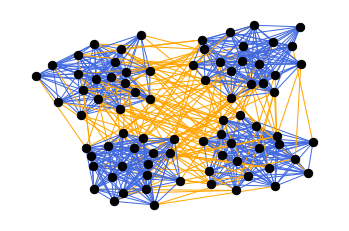

In [161]:
edgecolorlist=[]
for e in G.edges():
    if e[0]<n and e[1]<n:
        edgecolorlist.append('royalblue')
        continue
        
    if e[0]>n-1 and e[0]<2*n and e[1]>n-1 and e[1]<2*n:
        edgecolorlist.append('royalblue')
        continue
            
    if e[0]>2*n-1 and e[0]<3*n and e[1]>2*n-1 and e[1]<3*n:
        edgecolorlist.append('royalblue')        
        continue
            
    if e[0]>3*n-1 and e[1]>3*n-1:
        edgecolorlist.append('royalblue')
        continue
        
    edgecolorlist.append('orange')
    

f = plt.figure()
pos = nx.spring_layout(G)
nx.draw(G1, node_size=70, node_color='black', edge_color=edgecolorlist, pos=pos, ax=f.add_subplot(111))
f.savefig("graph1.png",dpi=300)

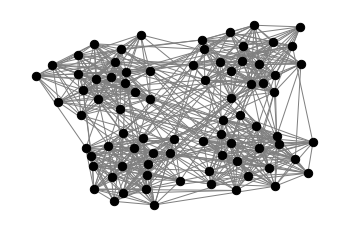

In [160]:
f = plt.figure()
nx.draw(G1, node_size=70, node_color='black', edge_color='grey', pos=pos, ax=f.add_subplot(111))
f.savefig("graph2.png",dpi=300)

Text(0.5, 0.5, 'q')

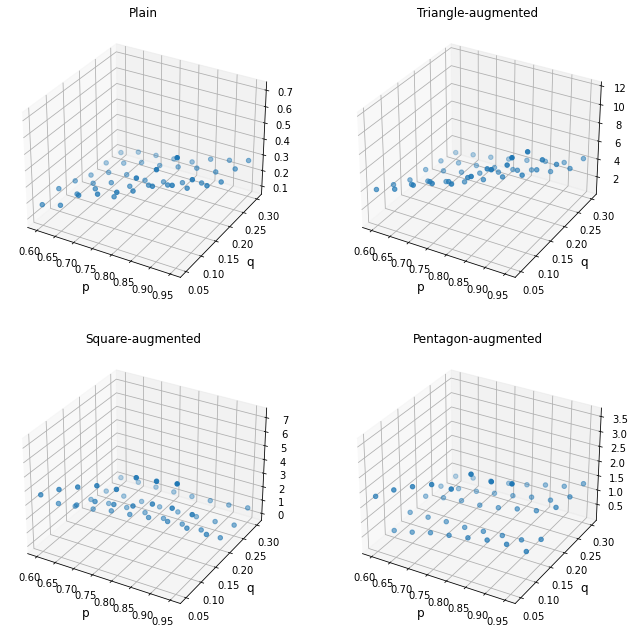

In [108]:
n=20

PlGap=[]
TrGap=[]
SqGap=[]
PentGap=[]


for p in np.linspace(0.6,0.95,8):
    for q in np.linspace(0.05,0.3,6):
        G = SBM(n,p,q)

        FRList_in_Pl = []
        FRList_out_Pl =[]
        FRList_in_T = []
        FRList_out_T =[]
        FRList_in_Sq = []
        FRList_out_Sq =[]
        FRList_in_Pent = []
        FRList_out_Pent =[]

        for e in G.edges():
            if e[0]<n and e[1]<n:
                FRList_in_Pl.append(AugFormanPl(e,G))
                FRList_in_T.append(AugFormanT(e,G))
                FRList_in_Sq.append(AugFormanSq(e,G))
                FRList_in_Pent.append(AugFormanPent(e,G))
                continue
        
            if e[0]>n-1 and e[0]<2*n and e[1]>n-1 and e[1]<2*n:
                FRList_in_Pl.append(AugFormanPl(e,G))
                FRList_in_T.append(AugFormanT(e,G))
                FRList_in_Sq.append(AugFormanSq(e,G))
                FRList_in_Pent.append(AugFormanPent(e,G))
                continue
            
            if e[0]>2*n-1 and e[0]<3*n and e[1]>2*n-1 and e[1]<3*n:
                FRList_in_Pl.append(AugFormanPl(e,G))
                FRList_in_T.append(AugFormanT(e,G))
                FRList_in_Sq.append(AugFormanSq(e,G))
                FRList_in_Pent.append(AugFormanPent(e,G))        
                continue
            
            if e[0]>3*n-1 and e[1]>3*n-1:
                FRList_in_Pl.append(AugFormanPl(e,G))
                FRList_in_T.append(AugFormanT(e,G))
                FRList_in_Sq.append(AugFormanSq(e,G))
                FRList_in_Pent.append(AugFormanPent(e,G))
                continue
        
            FRList_out_Pl.append(AugFormanPl(e,G))
            FRList_out_T.append(AugFormanT(e,G))    
            FRList_out_Sq.append(AugFormanSq(e,G))
            FRList_out_Pent.append(AugFormanPent(e,G))

        PlGap.append((p,q,abs(np.mean(FRList_in_Pl)-np.mean(FRList_out_Pl))/(np.sqrt((np.var(FRList_in_Pl)+np.var(FRList_out_Pl))/2))))
        TrGap.append((p,q,abs(np.mean(FRList_in_T)-np.mean(FRList_out_T))/(np.sqrt((np.var(FRList_in_T)+np.var(FRList_out_T))/2))))
        SqGap.append((p,q,abs(np.mean(FRList_in_Sq)-np.mean(FRList_out_Sq))/(np.sqrt((np.var(FRList_in_Sq)+np.var(FRList_out_Sq))/2))))
        PentGap.append((p,q,abs(np.mean(FRList_in_Pent)-np.mean(FRList_out_Pent))/(np.sqrt((np.var(FRList_in_Pent)+np.var(FRList_out_Pent))/2))))
        
fig = plt.figure(figsize=(11,11))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter3D([x[0] for x in PlGap], [x[1] for x in PlGap], [x[2] for x in PlGap])
ax.set_title('Plain')
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter3D([x[0] for x in TrGap], [x[1] for x in TrGap], [x[2] for x in TrGap])
ax.set_title('Triangle-augmented')
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter3D([x[0] for x in SqGap], [x[1] for x in SqGap], [x[2] for x in SqGap])
ax.set_title('Square-augmented')
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter3D([x[0] for x in PentGap], [x[1] for x in PentGap], [x[2] for x in PentGap])
ax.set_title('Pentagon-augmented')
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)

# Real networks

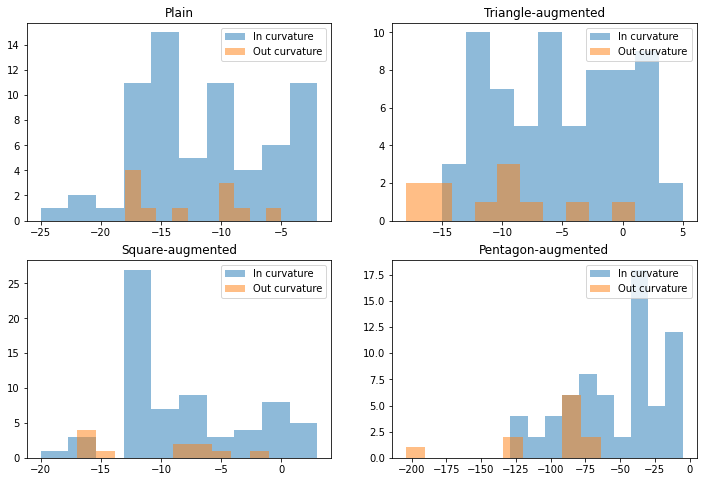

Plain curvature gap= 0.31011689886814076
Triangle curvature gap= 0.9358001642543323
Square curvature gap= 0.4305142185402063
Pentagon curvature gap= 1.3553566198857505


In [118]:
# Karate club

G0 = nx.karate_club_graph()
G = nx.convert_node_labels_to_integers(G0, first_label=0)

FRList_in_Pl = []
FRList_out_Pl =[]
FRList_in_T = []
FRList_out_T =[]
FRList_in_Sq = []
FRList_out_Sq =[]
FRList_in_Pent = []
FRList_out_Pent =[]

for e in G.edges():
    if G.nodes[e[0]]['club'] == G.nodes[e[1]]['club']:
        FRList_in_Pl.append(AugFormanPl(e,G))
        FRList_in_T.append(AugFormanT(e,G))
        FRList_in_Sq.append(AugFormanSq(e,G))
        FRList_in_Pent.append(AugFormanPent(e,G))
        
    else:
        FRList_out_Pl.append(AugFormanPl(e,G))
        FRList_out_T.append(AugFormanT(e,G))    
        FRList_out_Sq.append(AugFormanSq(e,G))
        FRList_out_Pent.append(AugFormanPent(e,G))
  

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

#bins0 = np.linspace(min(FRList_in_Pl), max(FRList_out_Pl), 100)
#bins1 = np.linspace(min(FRList_in_T), max(FRList_out_T), 100)
bins2 = np.linspace(min(FRList_in_Sq), max(FRList_out_Sq), 50)
bins3 = np.linspace(min(FRList_in_Pent), max(FRList_out_Pent), 50)

ax[0,0].hist(FRList_in_Pl, alpha=0.5, label='In curvature')
ax[0,0].hist(FRList_out_Pl, alpha=0.5, label='Out curvature')
ax[0,0].legend(loc='upper right')
ax[0,0].set_title('Plain')

ax[0,1].hist(FRList_in_T, alpha=0.5, label='In curvature')
ax[0,1].hist(FRList_out_T, alpha=0.5, label='Out curvature')
ax[0,1].legend(loc='upper right')
ax[0,1].set_title('Triangle-augmented')

ax[1,0].hist(FRList_in_Sq, alpha=0.5, label='In curvature')
ax[1,0].hist(FRList_out_Sq, alpha=0.5, label='Out curvature')
ax[1,0].legend(loc='upper right')
ax[1,0].set_title('Square-augmented')

ax[1,1].hist(FRList_in_Pent, alpha=0.5, label='In curvature')
ax[1,1].hist(FRList_out_Pent, alpha=0.5, label='Out curvature')
ax[1,1].legend(loc='upper right')
ax[1,1].set_title('Pentagon-augmented')
        

plt.show()

print("Plain curvature gap=",abs(np.mean(FRList_in_Pl)-np.mean(FRList_out_Pl))/(np.sqrt((np.var(FRList_in_Pl)+np.var(FRList_out_Pl))/2)))
print("Triangle curvature gap=",abs(np.mean(FRList_in_T)-np.mean(FRList_out_T))/(np.sqrt((np.var(FRList_in_T)+np.var(FRList_out_T))/2)))
print("Square curvature gap=",abs(np.mean(FRList_in_Sq)-np.mean(FRList_out_Sq))/(np.sqrt((np.var(FRList_in_Sq)+np.var(FRList_out_Sq))/2)))
print("Pentagon curvature gap=",abs(np.mean(FRList_in_Pent)-np.mean(FRList_out_Pent))/(np.sqrt((np.var(FRList_in_Pent)+np.var(FRList_out_Pent))/2)))

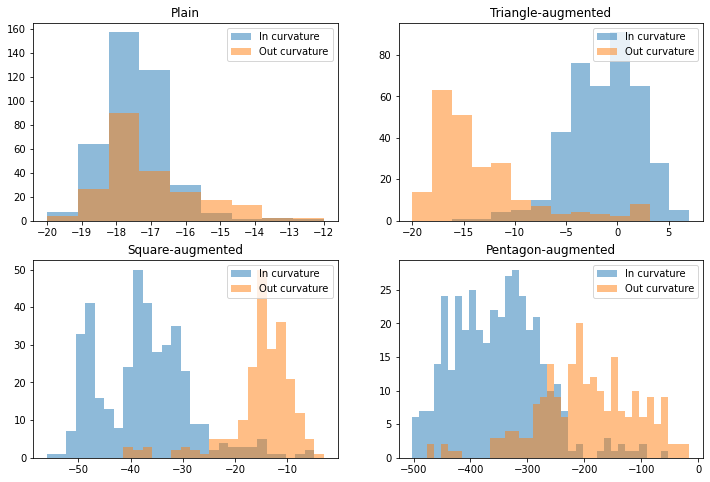

Plain curvature gap= 0.3429751353309278
Triangle curvature gap= 2.869741968800767
Square curvature gap= 2.9113281330885394
Pentagon curvature gap= 1.8769679219709243


In [36]:
# Football

G0 = nx.read_gml(r'C:\Users\Sergi\Desktop\Proyecto Networks\Proyecto OF\Networks\Football.gml')
G = nx.convert_node_labels_to_integers(G0, first_label=0)

FRList_in_Pl = []
FRList_out_Pl =[]
FRList_in_T = []
FRList_out_T =[]
FRList_in_Sq = []
FRList_out_Sq =[]
FRList_in_Pent = []
FRList_out_Pent =[]

for e in G.edges():
    if G.nodes[e[0]]['value'] == G.nodes[e[1]]['value']:
        FRList_in_Pl.append(AugFormanPl(e,G))
        FRList_in_T.append(AugFormanT(e,G))
        FRList_in_Sq.append(AugFormanSq(e,G))
        FRList_in_Pent.append(AugFormanPent(e,G))
        
    else:
        FRList_out_Pl.append(AugFormanPl(e,G))
        FRList_out_T.append(AugFormanT(e,G))    
        FRList_out_Sq.append(AugFormanSq(e,G))
        FRList_out_Pent.append(AugFormanPent(e,G))
  

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

bins0 = np.linspace(min(FRList_out_Pl), max(FRList_in_Pl), 10)
bins1 = np.linspace(min(FRList_out_T), max(FRList_in_T), 15)
bins2 = np.linspace(min(FRList_in_Sq), max(FRList_out_Sq), 30)
bins3 = np.linspace(min(FRList_in_Pent), max(FRList_out_Pent), 40)

ax[0,0].hist(FRList_in_Pl, bins0, alpha=0.5, label='In curvature')
ax[0,0].hist(FRList_out_Pl, bins0, alpha=0.5, label='Out curvature')
ax[0,0].legend(loc='upper right')
ax[0,0].set_title('Plain')

ax[0,1].hist(FRList_in_T, bins1, alpha=0.5, label='In curvature')
ax[0,1].hist(FRList_out_T, bins1, alpha=0.5, label='Out curvature')
ax[0,1].legend(loc='upper right')
ax[0,1].set_title('Triangle-augmented')

ax[1,0].hist(FRList_in_Sq, bins2, alpha=0.5, label='In curvature')
ax[1,0].hist(FRList_out_Sq, bins2, alpha=0.5, label='Out curvature')
ax[1,0].legend(loc='upper right')
ax[1,0].set_title('Square-augmented')

ax[1,1].hist(FRList_in_Pent, bins3, alpha=0.5, label='In curvature')
ax[1,1].hist(FRList_out_Pent, bins3, alpha=0.5, label='Out curvature')
ax[1,1].legend(loc='upper right')
ax[1,1].set_title('Pentagon-augmented')
        

plt.show()

print("Plain curvature gap=",abs(np.mean(FRList_in_Pl)-np.mean(FRList_out_Pl))/(np.sqrt((np.var(FRList_in_Pl)+np.var(FRList_out_Pl))/2)))
print("Triangle curvature gap=",abs(np.mean(FRList_in_T)-np.mean(FRList_out_T))/(np.sqrt((np.var(FRList_in_T)+np.var(FRList_out_T))/2)))
print("Square curvature gap=",abs(np.mean(FRList_in_Sq)-np.mean(FRList_out_Sq))/(np.sqrt((np.var(FRList_in_Sq)+np.var(FRList_out_Sq))/2)))
print("Pentagon curvature gap=",abs(np.mean(FRList_in_Pent)-np.mean(FRList_out_Pent))/(np.sqrt((np.var(FRList_in_Pent)+np.var(FRList_out_Pent))/2)))

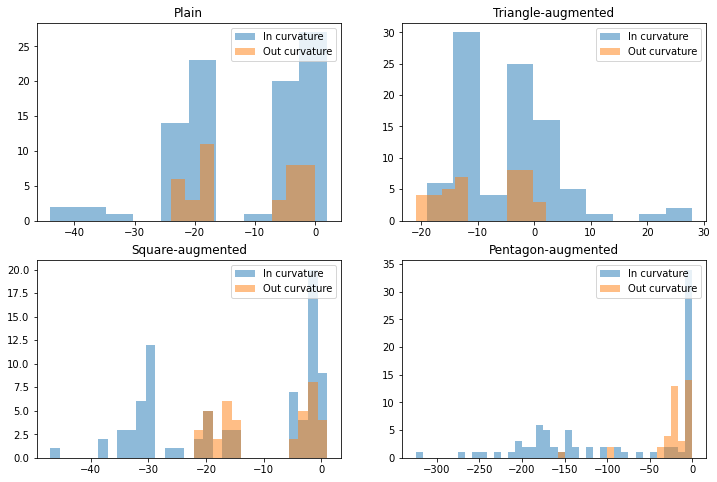

Plain curvature gap= 0.03613325926192398
Triangle curvature gap= 0.5269905920644773
Square curvature gap= 0.30107438013516935
Pentagon curvature gap= 0.8876779839024624


In [134]:
n=80
exp_deg=2
exp_comm=2
mu=0.3
G=nx.LFR_benchmark_graph(n, exp_deg, exp_comm, mu, min_degree=1, min_community=10, max_iters=5000, seed=None)

FRList_in_Pl = []
FRList_out_Pl =[]
FRList_in_T = []
FRList_out_T =[]
FRList_in_Sq = []
FRList_out_Sq =[]
FRList_in_Pent = []
FRList_out_Pent =[]

for e in G.edges():
    if e[1] in G.nodes[e[0]]['community']:
        FRList_in_Pl.append(AugFormanPl(e,G))
        FRList_in_T.append(AugFormanT(e,G))
        FRList_in_Sq.append(AugFormanSq(e,G))
        FRList_in_Pent.append(AugFormanPent(e,G))
        
    else:
        FRList_out_Pl.append(AugFormanPl(e,G))
        FRList_out_T.append(AugFormanT(e,G))    
        FRList_out_Sq.append(AugFormanSq(e,G))
        FRList_out_Pent.append(AugFormanPent(e,G))
  

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

#bins0 = np.linspace(min(FRList_in_Pl), max(FRList_out_Pl), 100)
bins1 = np.linspace(min(FRList_out_T), max(FRList_in_T), 30)
bins2 = np.linspace(min(FRList_in_Sq), max(FRList_out_Sq), 30)
bins3 = np.linspace(min(FRList_in_Pent), max(FRList_out_Pent), 40)

ax[0,0].hist(FRList_in_Pl, alpha=0.5, label='In curvature')
ax[0,0].hist(FRList_out_Pl, alpha=0.5, label='Out curvature')
ax[0,0].legend(loc='upper right')
ax[0,0].set_title('Plain')

ax[0,1].hist(FRList_in_T, alpha=0.5, label='In curvature')
ax[0,1].hist(FRList_out_T, alpha=0.5, label='Out curvature')
ax[0,1].legend(loc='upper right')
ax[0,1].set_title('Triangle-augmented')

ax[1,0].hist(FRList_in_Sq, bins2, alpha=0.5, label='In curvature')
ax[1,0].hist(FRList_out_Sq, bins2, alpha=0.5, label='Out curvature')
ax[1,0].legend(loc='upper right')
ax[1,0].set_title('Square-augmented')

ax[1,1].hist(FRList_in_Pent, bins3, alpha=0.5, label='In curvature')
ax[1,1].hist(FRList_out_Pent, bins3, alpha=0.5, label='Out curvature')
ax[1,1].legend(loc='upper right')
ax[1,1].set_title('Pentagon-augmented')
        

plt.show()

print("Plain curvature gap=",abs(np.mean(FRList_in_Pl)-np.mean(FRList_out_Pl))/(np.sqrt((np.var(FRList_in_Pl)+np.var(FRList_out_Pl))/2)))
print("Triangle curvature gap=",abs(np.mean(FRList_in_T)-np.mean(FRList_out_T))/(np.sqrt((np.var(FRList_in_T)+np.var(FRList_out_T))/2)))
print("Square curvature gap=",abs(np.mean(FRList_in_Sq)-np.mean(FRList_out_Sq))/(np.sqrt((np.var(FRList_in_Sq)+np.var(FRList_out_Sq))/2)))
print("Pentagon curvature gap=",abs(np.mean(FRList_in_Pent)-np.mean(FRList_out_Pent))/(np.sqrt((np.var(FRList_in_Pent)+np.var(FRList_out_Pent))/2)))

# Models: weight vs gap sign

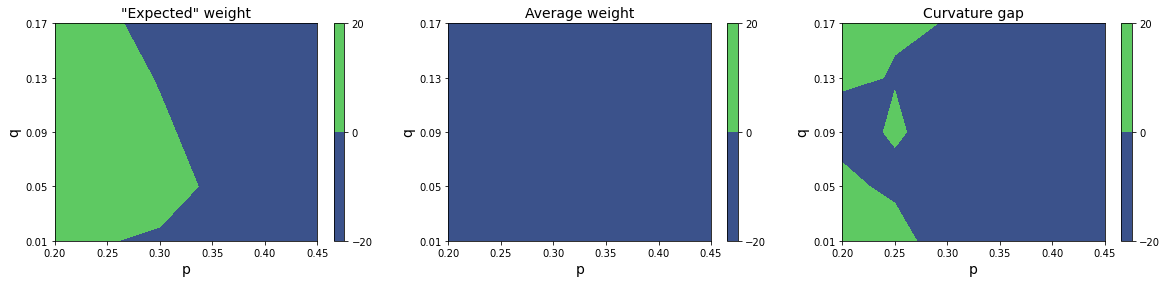

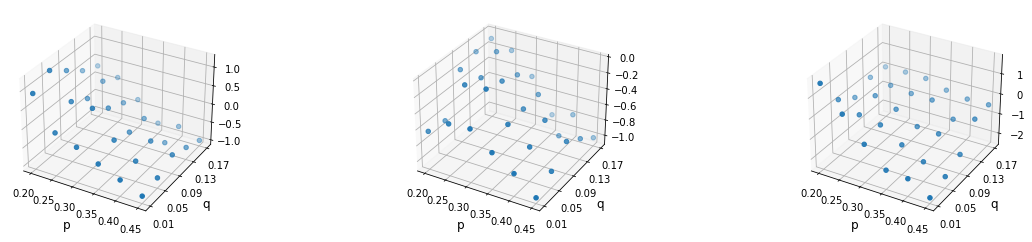

In [133]:
# Average and expected weight of hierarchical bipartite graph, and curvature gap (in - out)
n=20
P, Q = np.meshgrid(np.arange(0.2, 0.46, 0.05), np.arange(0.01, 0.21, 0.04))

exp_weight_in=np.zeros([5,6])
exp_weight_out=np.zeros([5,6])
exp_weight=np.zeros([5,6])

avg_weight_in=np.zeros([5,6])
avg_weight_out=np.zeros([5,6])
avg_weight=np.zeros([5,6])

curv_gap=np.zeros([5,6])

for p in range(0,6):
    for q in range(0,5):
        G=HierarchBipar(n, 0.2+0.05*p,0.01+0.04*q)
        FRList=np.zeros([len(G),len(G)])
        
        for e in G.edges():
            FRList[e[0],e[1]] = AugFormanSq(e,G)

        exp_weight_in[q,p]=Expected_in_bipar(G,n,FRList)
        exp_weight_out[q,p]=Expected_out_bipar(G,n,FRList)
        exp_weight[q,p]=Expected_bipar(G,exp_weight_in[q,p],exp_weight_out[q,p])
        
        avg_weight_in[q,p]=Average_in_bipar(G,n,FRList)
        avg_weight_out[q,p]=Average_out_bipar(G,n,FRList)
        avg_weight[q,p]=Average_bipar(G,avg_weight_in[q,p],avg_weight_out[q,p])
        
        curv_gap[q,p]=Curv_gap_bipar(G)
        #print(p,q,curv_gap[q,p])



fig, ax = plt.subplots(ncols=3, figsize=(20, 4))


ax02=ax[0].contourf(P, Q, exp_weight, levels=[-20,0,20])
ax[0].set_xlabel('p',size=14)
ax[0].set_ylabel('q',size=14)
ax[0].set_xticks(np.arange(0.2, 0.46, 0.05))
ax[0].set_yticks(np.arange(0.01, 0.21, 0.04))
ax[0].set_title('"Expected" weight',size=14)
fig.colorbar(ax02, ax=ax[0])

ax12=ax[1].contourf(P, Q, avg_weight, levels=[-20,0,20])
ax[1].set_xlabel('p',size=14)
ax[1].set_ylabel('q',size=14)
ax[1].set_xticks(np.arange(0.2, 0.46, 0.05))
ax[1].set_yticks(np.arange(0.01, 0.21, 0.04))
ax[1].set_title('Average weight',size=14)
fig.colorbar(ax12, ax=ax[1])


ax22=ax[2].contourf(P, Q, curv_gap, levels=[-20,0,20])
ax[2].set_xlabel('p',size=14)
ax[2].set_ylabel('q',size=14)
ax[2].set_xticks(np.arange(0.2, 0.46, 0.05))
ax[2].set_yticks(np.arange(0.01, 0.21, 0.04))
ax[2].set_title('Curvature gap',size=14)
fig.colorbar(ax12, ax=ax[2])

fig2 = plt.figure(figsize=(20,4))

ax = fig2.add_subplot(1, 3, 1, projection='3d')
ax.scatter3D(P,Q,exp_weight)
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)
ax.set_xticks(np.arange(0.2, 0.46, 0.05))
ax.set_yticks(np.arange(0.01, 0.21, 0.04))

ax = fig2.add_subplot(1, 3, 2, projection='3d')
ax.scatter3D(P,Q,avg_weight)
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)
ax.set_xticks(np.arange(0.2, 0.46, 0.05))
ax.set_yticks(np.arange(0.01, 0.21, 0.04))

ax = fig2.add_subplot(1, 3, 3, projection='3d')
ax.scatter3D(P,Q,curv_gap)
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)
ax.set_xticks(np.arange(0.2, 0.46, 0.05))
ax.set_yticks(np.arange(0.01, 0.21, 0.04))


plt.show()

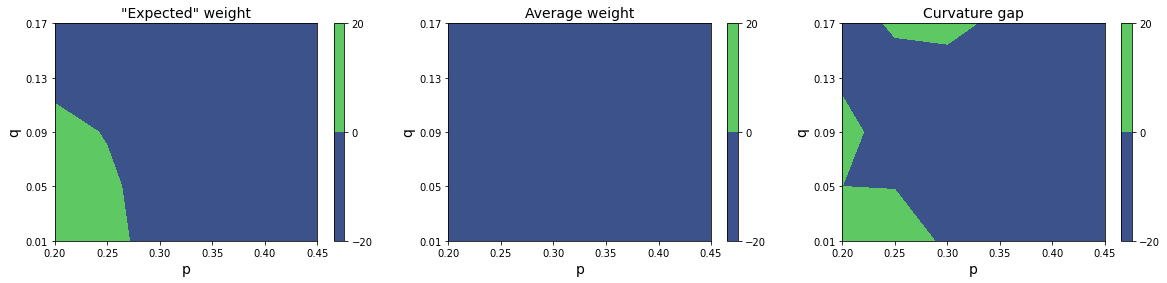

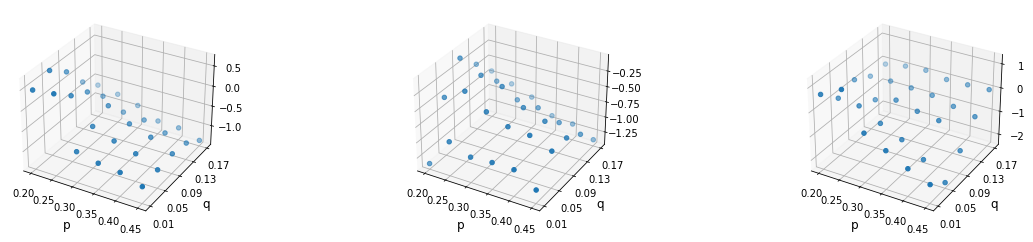

In [129]:
# Average and expected weight of hierarchical bipartite graph, and curvature gap (in - out)

n=20
P, Q = np.meshgrid(np.arange(0.2, 0.46, 0.05), np.arange(0.01, 0.21, 0.04))

exp_weight_in=np.zeros([5,6])
exp_weight_out=np.zeros([5,6])
exp_weight=np.zeros([5,6])

avg_weight_in=np.zeros([5,6])
avg_weight_out=np.zeros([5,6])
avg_weight=np.zeros([5,6])

curv_gap=np.zeros([5,6])

for p in range(0,6):
    for q in range(0,5):
        G=SBM(n, 0.2+0.05*p,0.01+0.04*q)
        FRList=np.zeros([len(G),len(G)])
        
        for e in G.edges():
            FRList[e[0],e[1]] = AugFormanSq(e,G)

        exp_weight_in[q,p]=Expected_in_SBM(G,n,FRList)
        exp_weight_out[q,p]=Expected_out_SBM(G,n,FRList)
        exp_weight[q,p]=Expected_SBM(G,exp_weight_in[q,p],exp_weight_out[q,p])
        
        avg_weight_in[q,p]=Average_in_SBM(G,n,FRList)
        avg_weight_out[q,p]=Average_out_SBM(G,n,FRList)
        avg_weight[q,p]=Average_SBM(G,avg_weight_in[q,p],avg_weight_out[q,p])
        
        curv_gap[q,p]=Curv_gap_SBM(G)
        #print(p,q,curv_gap[q,p])


fig, ax = plt.subplots(ncols=3, figsize=(20, 4))


ax02=ax[0].contourf(P, Q, exp_weight, levels=[-20,0,20])
ax[0].set_xlabel('p',size=14)
ax[0].set_ylabel('q',size=14)
ax[0].set_xticks(np.arange(0.2, 0.46, 0.05))
ax[0].set_yticks(np.arange(0.01, 0.21, 0.04))
ax[0].set_title('"Expected" weight',size=14)
fig.colorbar(ax02, ax=ax[0])

ax12=ax[1].contourf(P, Q, avg_weight, levels=[-20,0,20])
ax[1].set_xlabel('p',size=14)
ax[1].set_ylabel('q',size=14)
ax[1].set_xticks(np.arange(0.2, 0.46, 0.05))
ax[1].set_yticks(np.arange(0.01, 0.21, 0.04))
ax[1].set_title('Average weight',size=14)
fig.colorbar(ax12, ax=ax[1])


ax22=ax[2].contourf(P, Q, curv_gap, levels=[-20,0,20])
ax[2].set_xlabel('p',size=14)
ax[2].set_ylabel('q',size=14)
ax[2].set_xticks(np.arange(0.2, 0.46, 0.05))
ax[2].set_yticks(np.arange(0.01, 0.21, 0.04))
ax[2].set_title('Curvature gap',size=14)
fig.colorbar(ax12, ax=ax[2])

fig2 = plt.figure(figsize=(20,4))

ax = fig2.add_subplot(1, 3, 1, projection='3d')
ax.scatter3D(P,Q,exp_weight)
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)
ax.set_xticks(np.arange(0.2, 0.46, 0.05))
ax.set_yticks(np.arange(0.01, 0.21, 0.04))

ax = fig2.add_subplot(1, 3, 2, projection='3d')
ax.scatter3D(P,Q,avg_weight)
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)
ax.set_xticks(np.arange(0.2, 0.46, 0.05))
ax.set_yticks(np.arange(0.01, 0.21, 0.04))

ax = fig2.add_subplot(1, 3, 3, projection='3d')
ax.scatter3D(P,Q,curv_gap)
ax.set_xlabel('p',size=12)
ax.set_ylabel('q',size=12)
ax.set_xticks(np.arange(0.2, 0.46, 0.05))
ax.set_yticks(np.arange(0.01, 0.21, 0.04))


plt.show()